<a href="https://colab.research.google.com/github/syedayazsa/transfer-learning-for-segregation/blob/master/MobileNetV2_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **IMPORTING NECESSARY LIBRARIES**

In [0]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import os

# **LOADING AND UNZIPPING THE DATASET**

In [2]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1ReLMPYgrLXAPhAlo2pd4atv2TZa0fvjM' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1ReLMPYgrLXAPhAlo2pd4atv2TZa0fvjM" -O data.zip && rm -rf /tmp/cookies.txt

--2020-05-18 20:43:32--  https://docs.google.com/uc?export=download&confirm=RusO&id=1ReLMPYgrLXAPhAlo2pd4atv2TZa0fvjM
Resolving docs.google.com (docs.google.com)... 74.125.197.113, 74.125.197.100, 74.125.197.139, ...
Connecting to docs.google.com (docs.google.com)|74.125.197.113|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0k-6o-docs.googleusercontent.com/docs/securesc/apbhgpvlkicpbhd8c2ko23n687t27khm/i2bj7a4rub14kqpohh4ak1rglbef6bsm/1589834550000/14211000813324722452/15231287004219290662Z/1ReLMPYgrLXAPhAlo2pd4atv2TZa0fvjM?e=download [following]
--2020-05-18 20:43:32--  https://doc-0k-6o-docs.googleusercontent.com/docs/securesc/apbhgpvlkicpbhd8c2ko23n687t27khm/i2bj7a4rub14kqpohh4ak1rglbef6bsm/1589834550000/14211000813324722452/15231287004219290662Z/1ReLMPYgrLXAPhAlo2pd4atv2TZa0fvjM?e=download
Resolving doc-0k-6o-docs.googleusercontent.com (doc-0k-6o-docs.googleusercontent.com)... 108.177.98.132, 2607:f8b0:400e:c06::84
Connecting

# **SPECIFIYING PATHS TO DIRECTORY**

In [4]:
from glob import glob
base_path = '/content/split_dataset'
folders = glob('/content/split_dataset/train/*')
print(folders)

['/content/split_dataset/train/bullet_shells', '/content/split_dataset/train/band-aid', '/content/split_dataset/train/bottles', '/content/split_dataset/train/boots', '/content/split_dataset/train/automatic_rifles', '/content/split_dataset/train/knives', '/content/split_dataset/train/pistol_revolver', '/content/split_dataset/train/syringes']


In [0]:
IMAGE_SIZE = [224, 224]

train_path = '/content/split_dataset/train'
valid_path = '/content/split_dataset/validation'

# **PREPARING THE PRE-TRAINED MobileNetV2**

In [0]:
mobnet = MobileNetV2(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# don't train existing weights
for layer in mobnet.layers:
  layer.trainable = False

In [0]:
x = Flatten()(mobnet.output)
x = Dense(2048, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(2048, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.4)(x)
x = Dense(256, activation='relu')(x)
prediction = Dense(len(folders), activation='softmax')(x)

# **CREATING THE MobileNetV2 MODEL**

In [41]:
model_mobnet = Model(inputs=mobnet.input, outputs=prediction)
model_mobnet.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_7[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
____________________________________________________________________________________________

In [0]:
model_mobnet.compile(
  loss='categorical_crossentropy',
  optimizer= 'adam',
  metrics=['accuracy']
)

# **USING IMAGE AUGMENTATION**

In [10]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    rescale = 1./255,
    fill_mode = 'nearest')

validation_datagen = ImageDataGenerator(
    
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    rescale = 1./255,
    fill_mode = 'nearest')

training_set = train_datagen.flow_from_directory('/content/split_dataset/train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

validation_set = validation_datagen.flow_from_directory('/content/split_dataset/validation',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Using TensorFlow backend.


Found 6481 images belonging to 8 classes.
Found 1625 images belonging to 8 classes.


In [45]:
history_mobnet = model_mobnet.fit_generator(
  training_set,
  validation_data=validation_set,
  epochs=5,
  verbose = 1,
  steps_per_epoch=400,
  validation_steps=80
  )

Epoch 1/5
 15/400 [>.............................] - ETA: 2:59 - loss: 1.7467 - accuracy: 0.3708

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


400/400 [==============================] - 227s 567ms/step - loss: 0.4781 - accuracy: 0.8493 - val_loss: 0.4373 - val_accuracy: 0.9053
Epoch 2/5
400/400 [==============================] - 230s 575ms/step - loss: 0.2528 - accuracy: 0.9291 - val_loss: 0.2230 - val_accuracy: 0.9383
Epoch 3/5
400/400 [==============================] - 233s 583ms/step - loss: 0.2138 - accuracy: 0.9430 - val_loss: 0.1960 - val_accuracy: 0.9495
Epoch 4/5
400/400 [==============================] - 234s 585ms/step - loss: 0.1948 - accuracy: 0.9471 - val_loss: 0.1998 - val_accuracy: 0.9438
Epoch 5/5
400/400 [==============================] - 228s 569ms/step - loss: 0.1634 - accuracy: 0.9569 - val_loss: 0.1612 - val_accuracy: 0.9534


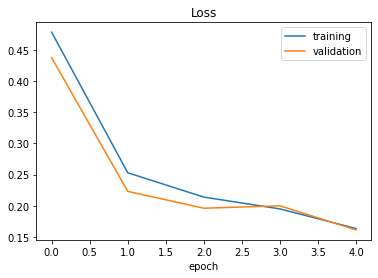

In [46]:
plt.plot(history_mobnet.history['loss'])
plt.plot(history_mobnet.history['val_loss'])
plt.title('Loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'])

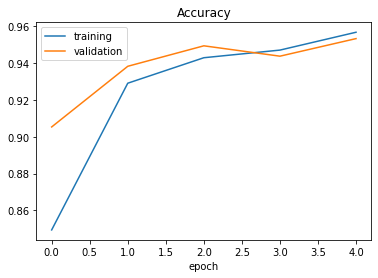

In [47]:
plt.plot(history_mobnet.history['accuracy'])
plt.plot(history_mobnet.history['val_accuracy'])
plt.title('Accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'])

In [48]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
model_mobnet.save('/content/gdrive/My Drive/Model/MobileNetV2.h5')

In [3]:
!unzip '/content/data.zip'

Streaming output truncated to the last 5000 lines.
  inflating: split_dataset/train/bottles/img (677).jpg  
  inflating: split_dataset/train/bottles/img (678).jpg  
  inflating: split_dataset/train/bottles/img (679).jpg  
  inflating: split_dataset/train/bottles/img (68).jpg  
  inflating: split_dataset/train/bottles/img (680).jpg  
  inflating: split_dataset/train/bottles/img (681).jpg  
  inflating: split_dataset/train/bottles/img (682).jpg  
  inflating: split_dataset/train/bottles/img (683).jpg  
  inflating: split_dataset/train/bottles/img (684).jpg  
  inflating: split_dataset/train/bottles/img (685).jpg  
  inflating: split_dataset/train/bottles/img (686).jpg  
  inflating: split_dataset/train/bottles/img (687).jpg  
  inflating: split_dataset/train/bottles/img (688).jpg  
  inflating: split_dataset/train/bottles/img (689).jpg  
  inflating: split_dataset/train/bottles/img (69).jpg  
  inflating: split_dataset/train/bottles/img (690).jpg  
  inflating: split_dataset/train/bottle